In [1]:
import os.path, sys

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

import expectation_reflection as ER
# import data processing and general DCA_ER tools
from data_processing import data_processing_msa2pdb
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)

from Bio.PDB import *

#from Bio.SubsMat.MatrixInfo import blosum62
import pickle

In [2]:
create_new = True
printing = True
removing_cols = True


data_path = Path('/data/cresswellclayec/DCA_ER/Pfam-A.full')
data_path = Path('/data/cresswellclayec/Pfam-A.full')

# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER' # Set DCA_ER directory
biowulf_dir = '%s/biowulf_full' % DCA_ER_dir

out_dir = '%s/protein_data/di/' % biowulf_dir
processed_data_dir = "%s/protein_data/data_processing_output" % biowulf_dir
pdb_dir = '%s/protein_data/pdb_data/' % biowulf_dir


pfam_dir = "/fdb/fastadb/pfam"

from data_processing import pdb2msa, data_processing_pdb2msa


import gzip, shutil
def gunzip(file_path, output_path):
    print('Unzipping %s to %s' % (file_path, output_path))
    with gzip.open(file_path,"rb") as f_in, open(output_path,"wb") as f_out:
        shutil.copyfileobj(f_in, f_out)


n_cpus = 20
pdb_id = '1zdr'
pdb_id = '4qt0'
pdb_id = '5r1k'


In [3]:
prody_df = pd.read_csv('%s/%s_pdb_df.csv' % (pdb_dir, pdb_id))
pdb2msa_row  = prody_df.iloc[0]
#try:
print(pdb2msa_row)
pfam_id = pdb2msa_row['Pfam']
pdb_id = pdb2msa_row['PDB ID']
pdb_chain = pdb2msa_row['Chain']

ref_outfile = Path(processed_data_dir, '%s_ref.fa' % pfam_id)

pfam_dimensions_file = "%s/%s_%s_pfam_dimensions.npy" % (processed_data_dir, pdb_id, pfam_id)
pfam_dimensions = np.load(pfam_dimensions_file)
if len(pfam_dimensions)==7:
    [n_col, n_seq, m_eff, ct_ER, ct_MF, ct_PMF, ct_PLM] = pfam_dimensions
elif len(pfam_dimensions)==6: # new pfam_dimensions created in run_method_comparison. we dont need MF..
    [n_col, n_seq, m_eff, ct_ER, ct_PMF, ct_PLM] = pfam_dimensions
elif len(pfam_dimensions)==3:
    [n_col, n_seq, m_eff] = pfam_dimensions

pdb_id = pdb2msa_row['PDB ID']
pfam_id = pdb2msa_row['Pfam']
# update Prody search DF (use same filename as pdb2msa() in data_processing

# LOAD MSA

Unnamed: 0                                                           0
PDB ID                                                            5r1k
Chain                                                                A
Polypeptide Index                                                    0
Pfam                                                           PF12134
accession                                                   PF12134.11
class                                                           Domain
id                                                       PRP8_domainIV
type                                                            Pfam-A
PDB Sequence         GAMNSSNYAELFNNDIKLFVDDTNVYRVTVHKTFEGNVATKAINGC...
ali_end                                                            228
ali_start                                                            3
bitscore                                                        407.48
end                                                                229
cond_e

In [4]:
dp_file = "%s/%s_%s_dp.pkl" % (processed_data_dir, pdb_id, pfam_id)
if not os.path.exists(dp_file):
    print('\nPDB DF with associated Protein Families\n', prody_df.loc[:,  [column for column in prody_df.columns if column not in ['locations', 'PDB Sequence']]].head())
    print("\n\nLooping through Prody Search DataFrame:", prody_df.head())
    rows_to_drop = []
    for ir, pdb2msa_row in enumerate(prody_df.iterrows()):
        print('\n\nGetting msa with following pdb2msa entry:\n', pdb2msa_row)
        try:
            dp_result =  data_processing_pdb2msa(data_path, prody_df.iloc[pdb2msa_row[0]], gap_seqs=0.2, gap_cols=0.2, prob_low=0.004,
                                   conserved_cols=0.8, printing=True, out_dir=processed_data_dir, pdb_dir=pdb_dir, letter_format=False,
                                   remove_cols=True, create_new=True)
            if dp_result is not None:
                [s0, removed_cols, s_index, tpdb, pdb_s_index] = dp_result
                break
            else:
                rows_to_drop.append(ir)
                continue
        except Exception as e:
            print('row %d got exception: ' % ir , e)
            print('moving on.. ')
            pass
    with open(dp_file, 'wb') as dp_handle:
        pickle.dump(dp_result, dp_handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(dp_file, 'rb') as dp_handle:
        dp_result = pickle.load(dp_handle)
    [s0, removed_cols, s_index, tpdb, pdb_s_index] = dp_result


In [5]:
s0_seq_wt = np.transpose(s0)
print('s0: ', s0.shape)
print('s0 seq_wt: ', s0_seq_wt.shape)

s0:  (589, 55)
s0 seq_wt:  (55, 589)


In [27]:
# number of positions
n_seq = s0.shape[0]
n_var = s0.shape[1]
n_seq_T = s0_seq_wt.shape[0]
n_var_T = s0_seq_wt.shape[1]

print("Number of residue positions:",n_var_T)
print("Number of sequences:",n_seq_T)

# number of aminoacids at each position
mxT = np.array([len(np.unique(s0_seq_wt[:,i])) for i in range(n_seq)])
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])

mx_cumsum = np.insert(mx.cumsum(),0,0)
mx_cumsum_T = np.insert(mxT.cumsum(),0,0)

i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T
i1i2_T = np.stack([mx_cumsum_T[:-1],mx_cumsum_T[1:]]).T


# number of variables
mx_sum = mx.sum()
mx_sum_T = mxT.sum()

# print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_seq
n_linear_T = mx_sum_T - n_seq_T


onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
sT = onehot_encoder.fit_transform(s0_seq_wt)
print(sT.shape)

onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
s = onehot_encoder.fit_transform(s0)
print(s.shape)

Number of residue positions: 589
Number of sequences: 55
(55, 9533)
(589, 381)


In [7]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1


In [28]:
# wT_file = "%s/%s_%s_wT.npy" % (processed_data_dir, pdb_id, pfam_id)
wT_file = 'wT_%s_%s.npy' %(pdb_id, pfam_id)

if os.path.exists(wT_file):
    wT = np.load(wT_file)
else:
    wT = np.zeros((mx.sum(),mx.sum()))
    h0T = np.zeros(mx.sum())


    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    #res = Parallel(n_jobs = 8)(delayed(predict_w)\
    res = Parallel(n_jobs = n_cpus-2)(delayed(predict_w)\
            (sT,i0,i1i2_T,niter_max=10,l2=100.0)\
            for i0 in range(n_var_T))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #-------------------------------
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        h01 = res[i0][0]
        w1 = res[i0][1]

        h0T[i1:i2] = h01
        wT[:i1,i1:i2] = w1[:i1,:]
        wT[i2:,i1:i2] = w1[i1:,:]

    # make w symmetric
    wT = (wT + wT.T)/2.
    np.save(wT_file , wT)

    
w_file = "%s/%s_%s_w.npy" % (processed_data_dir, pdb_id, pfam_id)
if os.path.exists(w_file):
    w = np.load(w_file)
else:
    w = np.zeros((mx.sum(),mx.sum()))
    h0 = np.zeros(mx.sum())


    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    #res = Parallel(n_jobs = 8)(delayed(predict_w)\
    res = Parallel(n_jobs = n_cpus-2)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #-------------------------------
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        h01 = res[i0][0]
        w1 = res[i0][1]

        h0[i1:i2] = h01
        w[:i1,i1:i2] = w1[:i1,:]
        w[i2:,i1:i2] = w1[i1:,:]
        np.save(w_file , w)

    # make w symmetric
    w = (w + w.T)/2.

In [16]:
print(w.shape)
print(wT.shape)


(381, 381)
(9533, 9533)


In [29]:
di = direct_info(s0,w)
diT = direct_info(s0_seq_wt,wT)


(589, 589)
(9533, 9533)
(55, 589)
(589, 589)


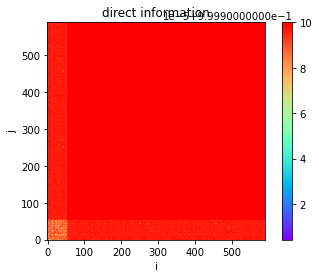

In [34]:
print(diT.shape)
print(wT.shape)
print(s0_seq_wt.shape)
diT_wt = np.exp(-diT)
print(diT_wt.shape)
plt.title('direct information')
# plt.imshow(diT_wt[:55,:55],cmap='rainbow',origin='lower')
plt.imshow(diT_wt,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
# plt.clim(.999999,1)
plt.colorbar(fraction=0.045, pad=0.05)

(589, 589)


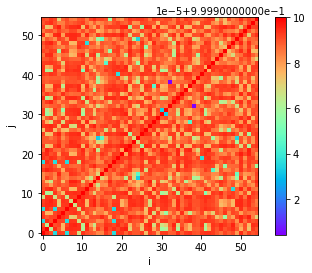

In [36]:
diT_wt = np.exp(-diT)
print(diT_wt.shape)
plt.imshow(diT_wt[:55,:55],cmap='rainbow',origin='lower')
# plt.imshow(diT_wt,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
# plt.clim(.999999,1)
plt.colorbar(fraction=0.045, pad=0.05)